In [1]:
import dirfile_functions as df
import numpy as np
import matplotlib.pyplot as plt
import pygetdata as gd
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import Ian_functions as load
import pandas as pd
from scipy import signal
roach_path = 'roach_data/'
ancillary_path = 'xy_stage/'
old_path = '2012_data/'
bolo_path = '2012_data/bolo_data/'

In [2]:
reload(load);

In [3]:
#loads the data in, third argument is the file type u16 is uint16 u32 is uint32 and s32 is signed int32
ra = load.loadArbData(old_path, 'ra', 'u32')
dec = load.loadArbData(old_path, 'dec', 's32')
bolo = load.loadArbData(bolo_path, 'n22c06', 'u32')

In [4]:
# linear conversion values for data
ra_a =  5.587935447693e-09
ra_b = 0
dec_a = 8.381903171539e-08
dec_b = 0
bolo_a = 6.903363270000e-07
bolo_b = -5.787153550000e+00

In [5]:
# conversion from dirfiles to useful data
bolo = bolo_a*bolo + bolo_b
ra = ra*ra_a
dec = dec*dec_a

In [6]:
# start of setting plotting ranges, probably should interpolate the data to bring ra dec to 100hz from 5hz
#bolo_start = 20*3652830
#bolo_range = 129450*20
#slow_range = 129450
#slow_start = 3652830
#arb range 8.4 days into flight, post SC failure, try new one below
# arbitrary range I created. seems to contain a scan?
#bolo_start = 20*(1603980-50000)
#bolo_range = 285000*20
#slow_range = 285000
#slow_start = 1603980-50000
#above looks to be a vela c scan, finding more
#bolo_start = 20*(269940)
#bolo_range = 29520*20
#slow_range = 29520
#slow_start = 269940
#above is probably carina nebula
bolo_start = 20*(269940)
bolo_range = 29520*20
slow_range = 29520
slow_start = 269940
#useful ranges of things found in the data, in index values

In [75]:
fs = 100
cutoff = 2
filt_bolo = load.butter_highpass_filter(bolo, cutoff, fs)

//anaconda/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [76]:
#set up the interpolation indices
t5 = np.arange(len(ra))/5.
t100 = np.arange(len(bolo))/100.

In [77]:
#interpolate ra and dec to 100hz from 5hz
ra_int = interp1d(t5[slow_start:slow_start+slow_range+1], ra[slow_start:slow_start+slow_range+1], kind='linear')
dec_int = interp1d(t5[slow_start:slow_start+slow_range+1], dec[slow_start:slow_start+slow_range+1], kind= 'linear')

In [78]:
#generate new arrays for time for the interpolated data
t100_use = t100[bolo_start+1:bolo_start+bolo_range-1]
t5_use = t5[slow_start:slow_start+slow_range]

In [79]:
#generate new arrays of interpolated data to match the bolometer data
dec_100 = dec_int(t100[bolo_start+1:bolo_start+bolo_range-1])
ra_100 = ra_int(t100[bolo_start+1:bolo_start+bolo_range-1])

In [80]:
# convert ra to degrees from hours in order to 
ra_100_deg = load.ra_to_deg(ra_100);

In [81]:
binned_bolo, size = load.arb_binning(ra_100_deg, dec_100, filt_bolo[bolo_start+1:bolo_start+bolo_range-1], .01166)
#hard coded the bin size so that each detection should be put in a 3x3 array around it

In [82]:
size

[401, 91]

In [102]:
#now start developing the map matrix for trial
def map_from_arb(arb_gen_out, size):
    map_matrix = []
    dec_block = []
    for n in range(size[1]):
        dec_block.append(0)
    for i in range(size[0]):
        map_matrix.append(dec_block)
    for m in range(len(binned_bolo)):
        i_ind = np.int(binned_bolo[m][1])-1
        j_ind = np.int(binned_bolo[m][2])-1
        if j_ind == 79 and i_ind == 80:
            print i_ind, j_ind, binned_bolo[m][0], m
        map_matrix[i_ind][j_ind] = map_matrix[i_ind][j_ind] + binned_bolo[m][0]
    return map_matrix

In [103]:
q = map_from_arb(binned_bolo, size)

80 79 -6.4657717899212144e-06 164218
80 79 -1.2802637214321782e-05 164219
80 79 -4.0055460907574195e-06 164220
80 79 -1.3364046284111576e-05 168266
80 79 -1.2483689079066826e-05 168267
80 79 1.2574032892868601e-05 250708
80 79 1.0175737043854619e-05 250709
80 79 9.083644572190281e-07 250710
80 79 6.5396070327268755e-06 328995
80 79 1.4405548149483444e-05 328996
80 79 6.514573191009216e-06 328997


In [89]:
q_fix = np.array(q)

In [99]:
print np.array(q[1])-np.array(q[2])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<IPython.core.display.Javascript object>


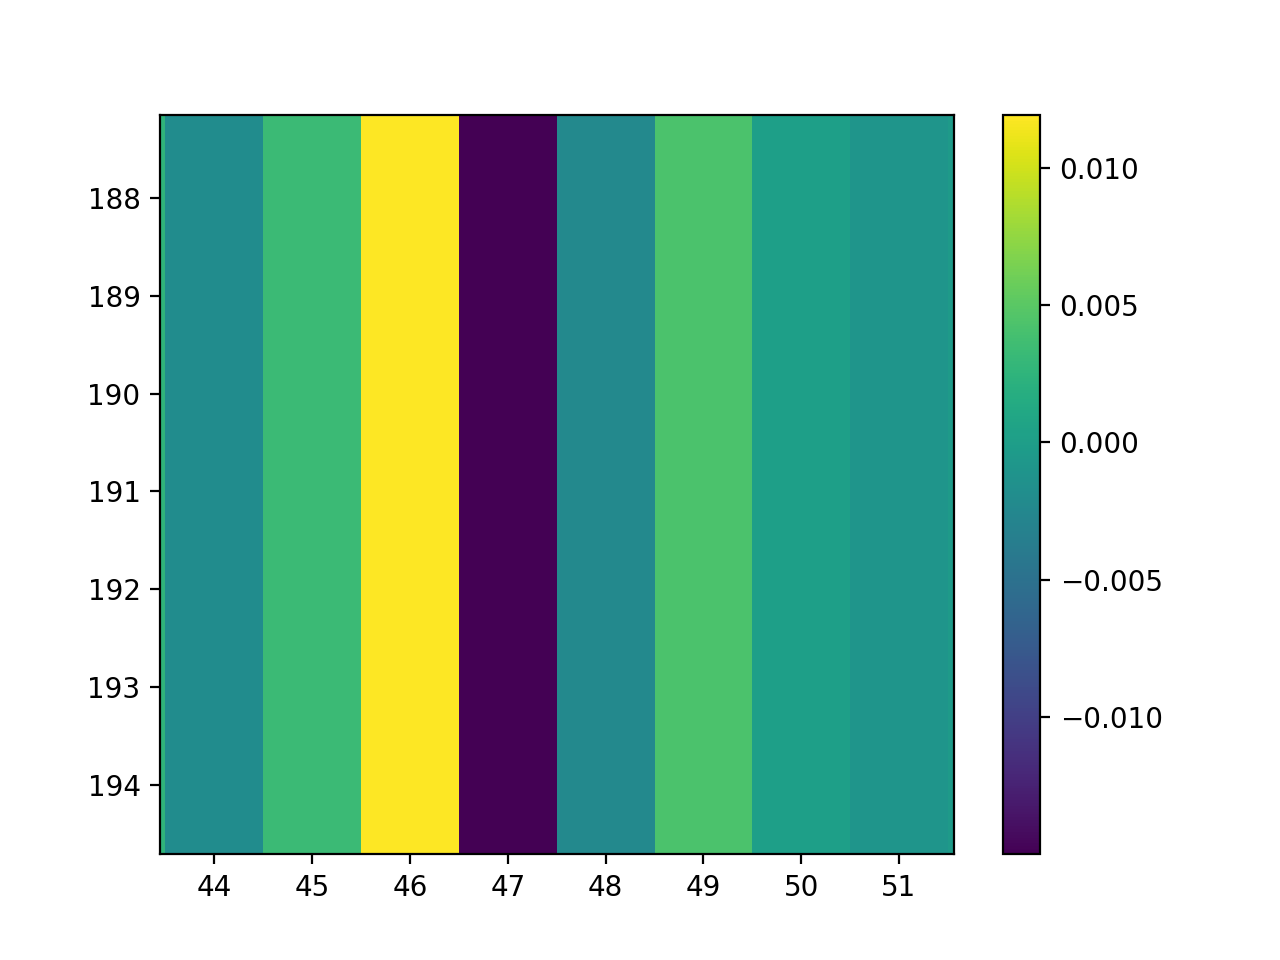

In [91]:
%matplotlib notebook
plt.imshow(q_fix)
plt.axis('equal')
plt.colorbar()